In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from copy import deepcopy
import traceback
import shap


In [2]:
# 数据准备
data = pd.read_csv("featureimportance.csv")
X = data[['N', 'SBET', 'Vmicro']].values.astype(np.float32)
y = data['CO2uptake'].values.reshape(-1, 1).astype(np.float32)

# 数据标准化
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

In [3]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[128, 17], dropout=0.1):
        super(SimpleMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        
        for dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = dim
            
        self.features = nn.Sequential(*layers)
        self.output = nn.Linear(prev_dim, 1)
        
    def forward(self, x):
        x = self.features(x)
        return self.output(x)

In [4]:
# 设备设置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参数设置
params_dict = {
    'lr': 0.007874797870587109,
    'batch_size': 16,
    'epochs': 100
}

# 5折交叉验证
def cross_validate_model(X, y, n_splits=5):
    """
    执行5折交叉验证
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # 存储所有折的结果
    all_predictions = []
    all_true_values = []
    all_test_indices = []
    all_fold_labels = []  # 新增：记录每个点属于哪一折
    fold_losses = []
    
    print("开始5折交叉验证...")
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X)):
        print(f"正在处理第 {fold + 1} 折...")
        
        # 划分训练和测试数据
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]
        
        # 创建数据加载器
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train_fold), 
            torch.FloatTensor(y_train_fold)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test_fold), 
            torch.FloatTensor(y_test_fold)
        )
        
        train_loader = DataLoader(train_dataset, batch_size=params_dict['batch_size'], shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=params_dict['batch_size'], shuffle=False)
        
        # 初始化模型
        model = SimpleMLP().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=params_dict['lr'])
        
        # 训练模型
        model.train()
        for epoch in range(params_dict['epochs']):
            epoch_loss = 0
            for inputs, targets in train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
        
        # 在测试集上评估
        model.eval()
        fold_predictions = []
        fold_true_values = []
        test_loss = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                fold_predictions.extend(outputs.cpu().numpy())
                fold_true_values.extend(targets.cpu().numpy())
                test_loss += criterion(outputs, targets).item()
        
        test_loss /= len(test_loader)
        fold_losses.append(test_loss)
        
        # 存储结果
        all_predictions.extend(fold_predictions)
        all_true_values.extend(fold_true_values)
        all_test_indices.extend(test_idx)
        all_fold_labels.extend([fold] * len(fold_predictions))  # 记录折数标签
        
        print(f"第 {fold + 1} 折测试损失: {test_loss:.4f}")
    
    # 计算平均性能
    mean_loss = np.mean(fold_losses)
    std_loss = np.std(fold_losses)
    print(f"\n交叉验证结果:")
    print(f"平均测试损失: {mean_loss:.4f} ± {std_loss:.4f}")
    
    return np.array(all_predictions), np.array(all_true_values), all_test_indices, np.array(all_fold_labels)

# 执行5折交叉验证
cv_predictions, cv_true_values, cv_test_indices, cv_fold_labels = cross_validate_model(X_scaled, y)

开始5折交叉验证...
正在处理第 1 折...
第 1 折测试损失: 0.7657
正在处理第 2 折...
第 2 折测试损失: 0.4629
正在处理第 3 折...
第 3 折测试损失: 0.2917
正在处理第 4 折...
第 4 折测试损失: 0.1677
正在处理第 5 折...
第 5 折测试损失: 0.4224

交叉验证结果:
平均测试损失: 0.4221 ± 0.2007



开始综合SHAP分析...


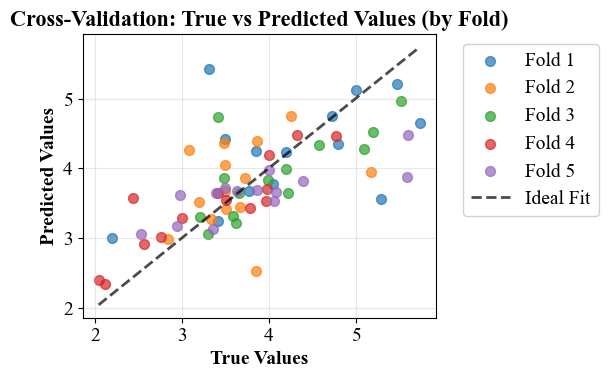

训练完整数据集模型用于SHAP分析...
计算整体数据集的SHAP值...


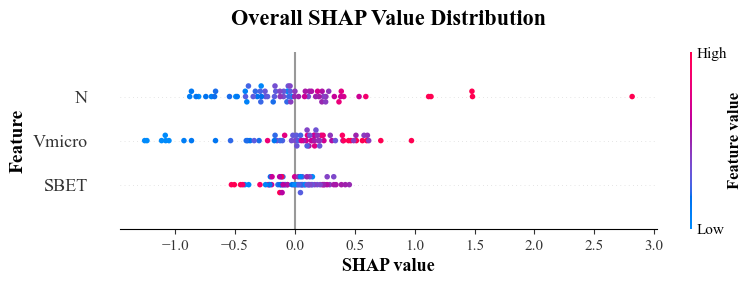

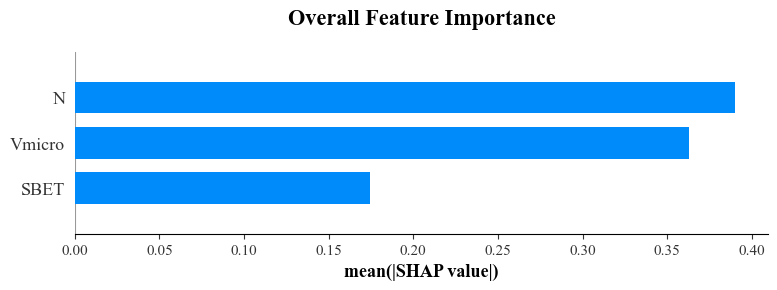


特征重要性排序:
  Feature  Importance
0       N    0.390020
2  Vmicro    0.363093
1    SBET    0.174569


In [5]:
def comprehensive_shap_analysis_cv(X, y, cv_predictions, cv_true_values, cv_fold_labels, feature_names=None, device='cpu', max_samples=1000):
    """
    基于交叉验证结果的综合SHAP分析
    """
    try:
        # 设置全局字体和样式
        plt.rcParams.update({
            'font.family': 'Times New Roman',
            'font.size': 14,
            'axes.titlesize': 16,
            'axes.labelsize': 14,
            'axes.labelweight': 'bold',
            'figure.autolayout': True
        })
        
        # ========== 图表1: 交叉验证预测值与真实值对比图（每折不同颜色） ==========
        plt.figure(figsize=(6, 4))
        
        # 定义5种不同的颜色
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
        fold_names = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']
        
        # 为每一折绘制不同颜色的点
        for fold in range(5):
            fold_mask = cv_fold_labels == fold
            if np.any(fold_mask):
                plt.scatter(cv_true_values[fold_mask], cv_predictions[fold_mask], 
                           alpha=0.7, color=colors[fold], label=fold_names[fold], s=50)
        
        # 绘制理想拟合线
        min_val = min(np.min(cv_true_values), np.min(cv_predictions))
        max_val = max(np.max(cv_true_values), np.max(cv_predictions))
        plt.plot([min_val, max_val], [min_val, max_val], 
                'k--', lw=2, alpha=0.7, label='Ideal Fit')

        
        plt.xlabel('True Values', fontweight='bold')
        plt.ylabel('Predicted Values', fontweight='bold')
        plt.title('Cross-Validation: True vs Predicted Values (by Fold)', fontweight='bold')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, framealpha=0.9)
        plt.grid(alpha=0.3)
        plt.savefig('cv_true_vs_predicted_by_fold.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()

        # ========== 为SHAP分析训练一个完整模型 ==========
        print("训练完整数据集模型用于SHAP分析...")
        
        # 使用完整数据集训练最终模型
        full_dataset = TensorDataset(torch.FloatTensor(X), torch.FloatTensor(y))
        full_loader = DataLoader(full_dataset, batch_size=params_dict['batch_size'], shuffle=True)
        
        final_model = SimpleMLP().to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(final_model.parameters(), lr=params_dict['lr'])
        
        # 训练最终模型
        final_model.train()
        for epoch in range(params_dict['epochs']):
            for inputs, targets in full_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = final_model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
        
        final_model.eval()
        
        # 数据子采样用于SHAP分析
        if len(X) > max_samples:
            idx = np.random.choice(len(X), max_samples, replace=False)
            X_sample, y_sample = X[idx], y[idx]
        else:
            X_sample, y_sample = X, y
        
        # 转换为tensor
        background = torch.FloatTensor(X_sample).to(device)
        
        # 创建SHAP解释器
        explainer = shap.DeepExplainer(final_model, background)
        print("计算整体数据集的SHAP值...")
        shap_values = explainer.shap_values(background)
        
        # 统一SHAP值格式
        def _process_shap(shap_vals):
            if isinstance(shap_vals, list):
                return shap_vals[0]
            elif len(shap_vals.shape) == 3:
                return shap_vals[:,:,0]
            return shap_vals
            
        shap_values = _process_shap(shap_values)

        # ========== 图表2: 整体SHAP值分布图 ==========
        plt.figure(figsize=(4, 2))
        shap.summary_plot(shap_values, X_sample, 
                         feature_names=feature_names,
                         show=False)
        
        plt.title('Overall SHAP Value Distribution', fontweight='bold', pad=20)
        plt.xlabel('SHAP value', fontweight='bold')
        plt.ylabel('Feature', fontweight='bold')
        
        plt.savefig('overall_shap_distribution.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()

        # ========== 图表3: 整体特征重要性图 ==========
        plt.figure(figsize=(4, 2))
        shap.summary_plot(shap_values, X_sample,
                         feature_names=feature_names,
                         plot_type='bar',
                         show=False)
                         
        plt.title('Overall Feature Importance', fontweight='bold', pad=20)
        plt.xlabel('mean(|SHAP value|)', fontweight='bold')
        
        plt.savefig('overall_feature_importance.png', dpi=600, bbox_inches='tight')
        plt.show()
        plt.close()
        
        # ========== 特征重要性分析结果 ==========
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': np.abs(shap_values).mean(axis=0)
        }).sort_values('Importance', ascending=False)
        
        print("\n特征重要性排序:")
        print(importance_df)
        
        return importance_df
        
    except Exception as e:
        print(f"SHAP分析出错: {str(e)}")
        traceback.print_exc()
        return None, None, None

# 执行综合SHAP分析
print("\n开始综合SHAP分析...")
importance_results = comprehensive_shap_analysis_cv(
    X=X_scaled,
    y=y,
    cv_predictions=cv_predictions,
    cv_true_values=cv_true_values,
    cv_fold_labels=cv_fold_labels,
    feature_names=['N', 'SBET', 'Vmicro'],
    device=device
)
